# CYCLEGAN TUTORIAL

**Author** - [Avik Pal](https://avik-pal.github.io/)

This is an **ADVANCED TUTORIAL** and it is recommended to go through the previous set of tutorials which cover the basics of torchgan. In this tutorial we shall be implementing the paper [
Unpaired Image-to-Image Translation using Cycle-Consistent Adversarial Networks by Zhu et. al.](https://arxiv.org/abs/1703.10593).

Since this is a fairly advanced model, we will have to subclass most of the features provided by torchgan. The tutorial can be broadly categorized into 3 major components:

1. The Generator and the Discriminator Models
2. The Loss Functions
3. A Custom Trainer

We also need to write our own DataLoader for the **cityscapes** dataset. It is fairly simple to modify the DataLoader to support other datasets and we would highly encourage you to do so in order to get more familiar with the way *torchgan and Pytorch in general work*.

In [1]:
import os, sys, glob, random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torchvision.transforms as transforms
import torchvision.utils as vutils
import torchgan
from torchgan.models import Generator, Discriminator
from torchgan.trainer import Trainer
from torchgan.losses import GeneratorLoss, DiscriminatorLoss,\
                            least_squares_generator_loss, least_squares_discriminator_loss
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Set random seed for reproducibility
manualSeed = 999
random.seed(manualSeed)
torch.manual_seed(manualSeed)
print("Random Seed: ", manualSeed)

Random Seed:  999


## LOADING THE DATASET

We are going to work with the **Cityscapes Data**. You should use [this script](https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix/blob/master/datasets/download_cyclegan_dataset.sh) to download the data.

The downloaded data should be present in the following format:

```
    ---> cityscapes
        ---> trainA
            ---> ...
            ---> ...
                .
                .
                .
        ---> trainB
            ---> ...
            ---> ...
                .
                .
                .
        ---> testA
            ---> ...
            ---> ...
                .
                .
                .
        ---> testB
            ---> ...
            ---> ...
                .
                .
                .
```
The `...` signify the image files. For the sake of this tutorial we will only make use of the `train` files, though ideally for inference you should be using the `test` files.

As you can observe that the `__getitem__` function returns a `dict`. This is a vital detail. The reson for this shall be explained when we will subclass the `Trainer`. But remember that sending a `list` or `tuple` will create issues for our code.

In [3]:
class ImageDataset(Dataset):
    def __init__(self, root, transform=None, mode='train'):
        self.transform = transform
        self.files_A = sorted(glob.glob(os.path.join(root, '{}A'.format(mode)) + '/*.*'))
        self.files_B = sorted(glob.glob(os.path.join(root, '{}B'.format(mode)) + '/*.*'))

    def __getitem__(self, index):
        item_A = self.transform(Image.open(self.files_A[index % len(self.files_A)]))
        item_B = self.transform(Image.open(self.files_B[index % len(self.files_B)]))
        return {'A': item_A, 'B': item_B}

    def __len__(self):
        return max(len(self.files_A), len(self.files_B))

In [4]:
dataset = ImageDataset("./datasets/cityscapes",
                       transform=transforms.Compose([transforms.CenterCrop((64, 64)),
                                                     transforms.ToTensor(),
                                                     transforms.Normalize(mean=(0.5, 0.5, 0.5),
                                                                          std=(0.5, 0.5, 0.5))]))

This `batch_size` works on a **12GB Nvidia 1080Ti GPU**. If you are trying this notebook in a less powerful machine please reduce the batch_size otherwise you will most likely encounter a CUDA Out Of Memory Issue.

In [5]:
dataloader = DataLoader(dataset, batch_size=64, shuffle=False, num_workers=8)

## VISUALIZE THE TRAINING DATA

Lets display the pictures that will serve as our training dataset.
We will simultaneously train 2 generators, **gen_a2b** and **gen_b2a**. **gen_a2b** will learn to translate images of **type A** (the normal images) to images of **type B** (the segmented images). **gen_b2a** will learn to do the reverse translation.

**Note**: *Even though we are using paired images in this tutorial, CycleGAN can work with Unpaired Data. For some datasets you shall not have paired images, so feel free to use unpaired data. Only thing to take into account would be to use some randomization while selected the image pair in such a scenario. The easiest way would be to replace the selection line for image_B to `np.random.randint(0, len(self.files_B))`*

In [6]:
a = next(iter(dataloader))

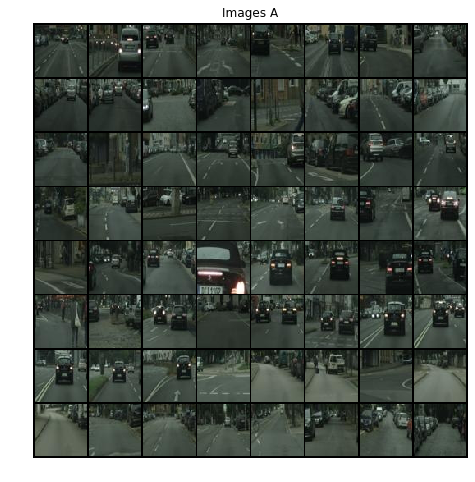

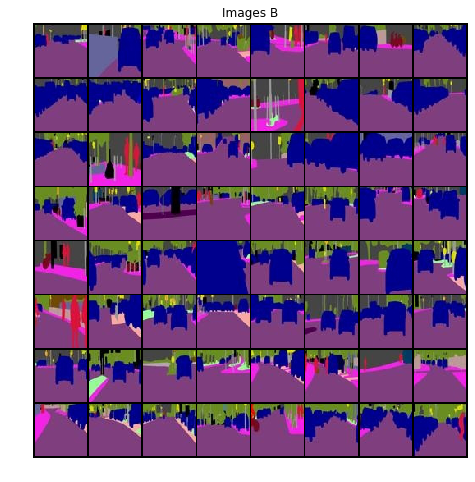

In [ ]:
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Images A")
plt.imshow(np.transpose(vutils.make_grid(a['A'].to(torch.device("cuda:0"))[:64], padding=2, normalize=True).cpu(),(1,2,0)))
plt.show()
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Images B")
plt.imshow(np.transpose(vutils.make_grid(a['B'].to(torch.device("cuda:0"))[:64], padding=2, normalize=True).cpu(),(1,2,0)))
plt.show()

## DEFINING THE GENERATOR & DISCRIMINATOR

First we will be defining the building blocks of the model. TorchGAN provides standard ResidualBlocks however, we need a specific form of ResidualBlock for CycleGAN model. In the paper [
Instance Normalization: The Missing Ingredient for Fast Stylization by Ulyanov et. al.](https://arxiv.org/abs/1607.08022), the authors describe the use of Instance Normalization for Style Transfer. On a similar context, we shall be using Instance Norm instead of Batch Norm and finally swap the **Zero Padding** of the Convolutional Layer with **Reflection Padding**.

In [ ]:
class ResidualBlock(nn.Module):
    def __init__(self, in_features):
        super(ResidualBlock, self).__init__()
        self.conv_block = nn.Sequential(nn.ReflectionPad2d(1),
                                        nn.Conv2d(in_features, in_features, 3),
                                        nn.InstanceNorm2d(in_features),
                                        nn.ReLU(inplace=True),
                                        nn.ReflectionPad2d(1),
                                        nn.Conv2d(in_features, in_features, 3),
                                        nn.InstanceNorm2d(in_features))

    def forward(self, x):
        return x + self.conv_block(x)

The **CycleGAN Generator** has 3 parts:

1. A downsampling network: It is composed of 3 convolutional layers  (together with the regular padding, normalization and activation layers).
2. A chain of residual networks built using the Residual Block. You can try to vary the `res_blocks` parameter and see the results.
3. A upsampling network: It is composed of 3 transposed convolutional layers.

We also need to define a `sampler` function which provides a visual standard for seeing how the generator is performing. The sampler must receive 2 inputs `sample_size` and `device` and it should return a list of the arguments needed by the `forward` function of the generator

In [ ]:
class CycleGANGenerator(Generator):
    def __init__(self, image_batch, in_channels=3, out_channels=3, res_blocks=5):
        super(CycleGANGenerator, self).__init__(in_channels)

        self.image_batch = image_batch

        # Initial convolution block
        model = [nn.ReflectionPad2d(3), nn.Conv2d(in_channels, 64, 7),
                 nn.InstanceNorm2d(64), nn.ReLU(inplace=True)]

        # Downsampling
        in_features = 64
        out_features = in_features * 2
        for _ in range(2):
            model += [nn.Conv2d(in_features, out_features, 4, stride=2, padding=1),
                      nn.InstanceNorm2d(out_features), nn.ReLU(inplace=True)]
            in_features = out_features
            out_features = in_features * 2

        # Residual blocks
        for _ in range(res_blocks):
            model += [ResidualBlock(in_features)]

        # Upsampling
        out_features = in_features // 2
        for _ in range(2):
            model += [nn.ConvTranspose2d(in_features, out_features, 4, stride=2, padding=1),
                      nn.InstanceNorm2d(out_features), nn.ReLU(inplace=True)]
            in_features = out_features
            out_features = in_features // 2

        # Output layer
        model += [nn.ReflectionPad2d(3), nn.Conv2d(64, out_channels, 7), nn.Tanh()]

        self.model = nn.Sequential(*model)

        self._weight_initializer()

    def forward(self, x):
        return self.model(x)

    def sampler(self, sample_size, device):
        return [self.image_batch.to(device)]

The **CycleGAN Discriminator** is like the standard DCGAN Discriminator. The only difference is the normalization used. Just like in the Generator we shall be using Instance Normalization even in the Discriminator.

In [ ]:
class CycleGANDiscriminator(Discriminator):
    def __init__(self, in_channels=3):
        super(Discriminator, self).__init__()

        def discriminator_block(in_filters, out_filters, normalize=True):
            layers = [nn.Conv2d(in_filters, out_filters, 4, stride=2, padding=1)]
            if normalize:
                layers.append(nn.InstanceNorm2d(out_filters))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *discriminator_block(in_channels, 64, normalize=False),
            *discriminator_block(64, 128),
            *discriminator_block(128, 256),
            *discriminator_block(256, 512),
            nn.ZeroPad2d((1, 0, 1, 0)),
            nn.Conv2d(512, 1, 4, padding=1))

        self._weight_initializer()
    
    def forward(self, x):
        return self.model(x)

## LOSS FUNCTIONS

The Generator Loss is composed of 3 parts. They are described below:

1. **GAN Loss**: It is the standard generator loss of the Least Squares GAN. We use the functional forms of the losses to implement this part.
$$L_{GAN} = \frac{1}{4} \times ((D_A(G_{B2A}(Image_B)) - 1)^2 + (D_B(G_{A2B}(Image_A)) - 1)^2)$$
2. **Identity Loss**: It computes the similarity of a real image of type B and a fake image B generated from image A and vice versa. The similarity is measured using the $L_1$ Loss.
$$L_{identity} = \frac{1}{2} \times (||G_{B2A}(Image_B) - Image_A||_1 + ||G_{A2B}(Image_A) - Image_B||_1)$$
3. **Cycle Consistency Loss**: This loss computes the similarity of the original image and the image generated by a composition of the 2 generators. This allows cyclegan to deak with unpaired images. We reconstruct the original image and try to minimize the $L_1$ norm between the original images and this reconstructed image.
$$L_{cycle\_consistency} = \frac{1}{2} \times (||G_{B2A}(G_{A2B}(Image_A)) - Image_A||_1 + ||G_{A2B}(G_{B2A}(Image_B)) - Image_B||_1)$$

The losses can be decomposed into 3 different loss functions, however, doing that would not be in our best interests. In that case we shall be backpropagating 3 times through the networks. This will lead to a huge impact in the performance of your code. So the general rule in torchgan is to club losses together if they improve the performance of your model otherwise keep them seperate (this will lead to better loss visualization) and feed them in through the losses list.

Now let us see the naming convention for the `train_ops` arguments. We simply list all the variables stored in the Trainer that we need. We are guaranteed to get all these variables if they are present in the Trainer. In case something is not, you shall receive a well defined error message stating which argument was not found. Then you can define that argument or use the `set_arg_map` to fix that. The details of this method is clearly demonstrated in the documentation.

In [ ]:
class CycleGANGeneratorLoss(GeneratorLoss):
    def train_ops(self, gen_a2b, gen_b2a, dis_a, dis_b, optimizer_gen_a2b, optimizer_gen_b2a,
                  image_a, image_b):
        optimizer_gen_a2b.zero_grad()
        optimizer_gen_b2a.zero_grad()
        fake_a = gen_b2a(image_b)
        fake_b = gen_a2b(image_a)
        loss_identity = 0.5 * (F.l1_loss(fake_a, image_a) + F.l1_loss(fake_b, image_b))
        loss_gan = 0.5 * (least_squares_generator_loss(dis_a(fake_a)) +\
                   least_squares_generator_loss(dis_b(fake_b)))
        loss_cycle_consistency = 0.5 * (F.l1_loss(gen_a2b(fake_a), image_b) +\
                                 F.l1_loss(gen_b2a(fake_b), image_a))
        loss = loss_identity + loss_gan + loss_cycle_consistency
        loss.backward()
        optimizer_gen_a2b.step()
        optimizer_gen_b2a.step()
        return loss.item()

The Discriminator as mentioned before is same as the normal DCGAN Discriminator. As such even the loss function for that is same as that of the standard GAN. Again we list all the required variables in the train_ops and we are guaranteed to get those from the Trainer.

$$L_{GAN} = \frac{1}{4} \times (((D_A(Image_A) - 1)^2 - (D_A(G_{B2A}(Image_B))^2) + ((D_B(Image_B) - 1)^2 - (D_B(G_{A2B}(Image_A))^2))$$

In [ ]:
class CycleGANDiscriminatorLoss(DiscriminatorLoss):
    def train_ops(self, gen_a2b, gen_b2a, dis_a, dis_b, optimizer_dis_a, optimizer_dis_b,
                  image_a, image_b):
        optimizer_dis_a.zero_grad()
        optimizer_dis_b.zero_grad()
        fake_a = gen_b2a(image_b).detach()
        fake_b = gen_a2b(image_a).detach()
        loss = 0.5 * (least_squares_discriminator_loss(dis_a(image_a), dis_a(fake_a)) +
                      least_squares_discriminator_loss(dis_b(image_b), dis_b(fake_b)))
        loss.backward()
        optimizer_dis_a.step()
        optimizer_dis_b.step()
        return loss.item()

## DEFINING THE CUSTOM TRAINER FOR CYCLEGAN

Even though the Trainer has been designed to be as general as possible, it cannot handle arbitrary input data format. However, the current design provides a neat trick to by-pass this shortcoming. The data is handled in 3 different ways:

1. If it is a list or tuple, then *real_inputs* stores the first element and *labels* stores the second element. Since we expect these to be tensors we push them to device. This might be troublesome in cases where the input data from the data loader is not a tensor, but even that can be handled.
2. If it is a torch Tensor we simply save it in the *real_inputs* and is pushed to the device.
3. Now the $3^{rd}$ and the most interesting one. In case any of the above are not satisfied we shall be storing the data in *real_inputs*. Note that we leave this format completely untouched. So you can do anything that you need to do with it. Hence we recommend that if you have custom data use a dictionary to fetch it.

Now lets come to the trick I mentioned before. Since we defined our dataset to return `dict`. We are now guaranteed to have the untouched data in a variable named `real_inputs`. So we simply redefine the `train_iter_custom` function which is called everytime before we call the `train_iter`. In this function we shall simply unpack the data into 2 variables `image_a` and `image_b`, exactly what the `train_ops` needed.

In [ ]:
class CycleGANTrainer(Trainer):
    def train_iter_custom(self):
        self.image_a = self.real_inputs['A'].to(self.device)
        self.image_b = self.real_inputs['B'].to(self.device)

In [ ]:
device = torch.device("cuda:0")

`image_batch` will act as a reference and we can visualize its transformation over the course of the model training.

In [ ]:
image_batch = next(iter(dataloader))

In [ ]:
network_config = {
    "gen_a2b": {"name": CycleGANGenerator, "args": {"image_batch": image_batch['A']},
                "optimizer": {"name": Adam, "args": {"lr": 0.0001, "betas": (0.5, 0.999)}}},
    "gen_b2a": {"name": CycleGANGenerator, "args": {"image_batch": image_batch['B']},
                "optimizer": {"name": Adam, "args": {"lr": 0.0001, "betas": (0.5, 0.999)}}},
    "dis_a": {"name": CycleGANDiscriminator,
              "optimizer": {"name": Adam, "args": {"lr": 0.0001, "betas": (0.5, 0.999)}}},
    "dis_b": {"name": CycleGANDiscriminator,
              "optimizer": {"name": Adam, "args": {"lr": 0.0001, "betas": (0.5, 0.999)}}}
}

In [ ]:
losses = [CycleGANGeneratorLoss(), CycleGANDiscriminatorLoss()]

Another important detail is the last 2 arguments. Since at the time of instantiation we shall be checking if all the variables required by the train_ops are present in the trainer, we need to make sure that the object has some attributes named `image_a` and `image_b`. The trainer stores any keyword argument that it receives, hence this is the simplest way to prevent that error

In [ ]:
trainer = CycleGANTrainer(network_config, losses, device=device, epochs=100, image_a=None, image_b=None)

In [ ]:
trainer(dataloader)

Saving Model at './model/gan0.model'


/data/avikpal/miniconda3/lib/python3.7/site-packages/torch/serialization.py:241: UserWarning: Couldn't retrieve source code for container of type CycleGANGeneratorLoss. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/data/avikpal/miniconda3/lib/python3.7/site-packages/torch/serialization.py:241: UserWarning: Couldn't retrieve source code for container of type CycleGANDiscriminatorLoss. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch 1 Summary
gen_a2b Mean Gradients : 25.373855783972246
gen_b2a Mean Gradients : 39.881884383987945
dis_a Mean Gradients : 9.00916113148021
dis_b Mean Gradients : 5.737849600937892
Mean Running Discriminator Loss : 0.5342410517499802
Mean Running Generator Loss : 1.075072907386942
Generating and Saving Images to ./images/epoch1_gen_a2b.png
Generating and Saving Images to ./images/epoch1_gen_b2a.png

Saving Model at './model/gan1.model'
Epoch 2 Summary
gen_a2b Mean Gradients : 14.481977953249341
gen_b2a Mean Gradients : 22.743691111338652
dis_a Mean Gradients : 5.784760900086345
dis_b Mean Gradients : 5.197409447200781
Mean Running Discriminator Loss : 0.45670214897774636
Mean Running Generator Loss : 0.9196841570925205
Generating and Saving Images to ./images/epoch2_gen_a2b.png
Generating and Saving Images to ./images/epoch2_gen_b2a.png

Saving Model at './model/gan2.model'
Epoch 3 Summary
gen_a2b Mean Gradients : 10.391435876424984
gen_b2a Mean Gradients : 16.175424935190154
dis_a

## VISUALIZING THE GENERATED DATA

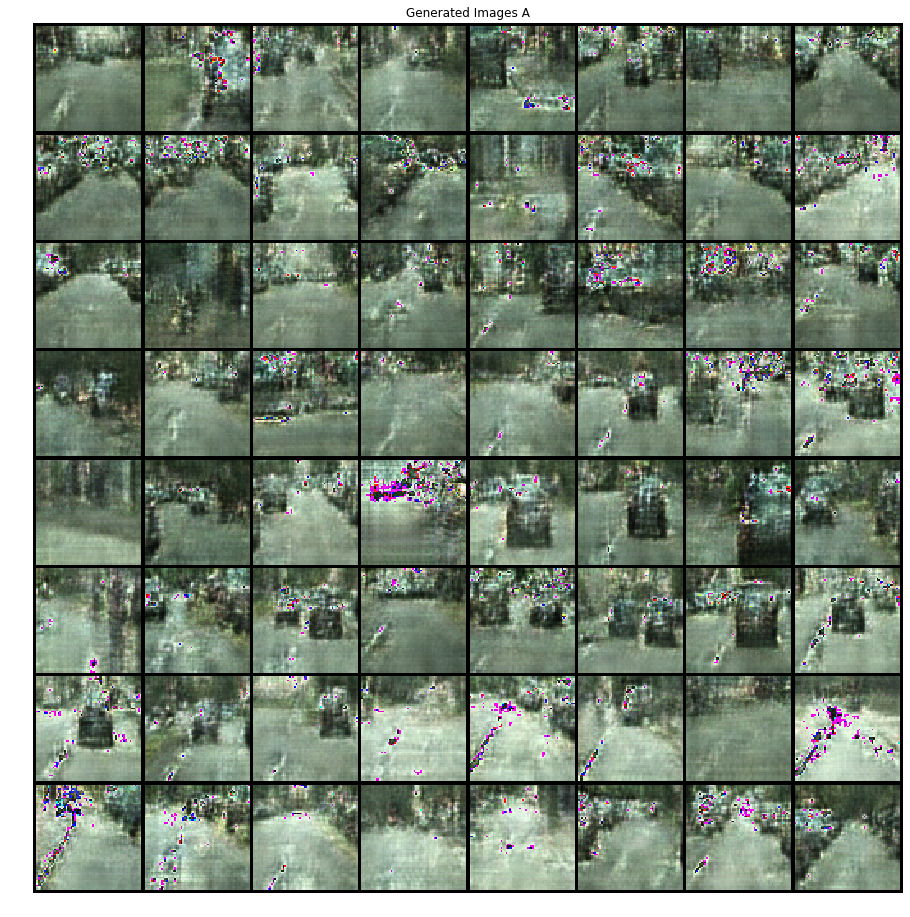

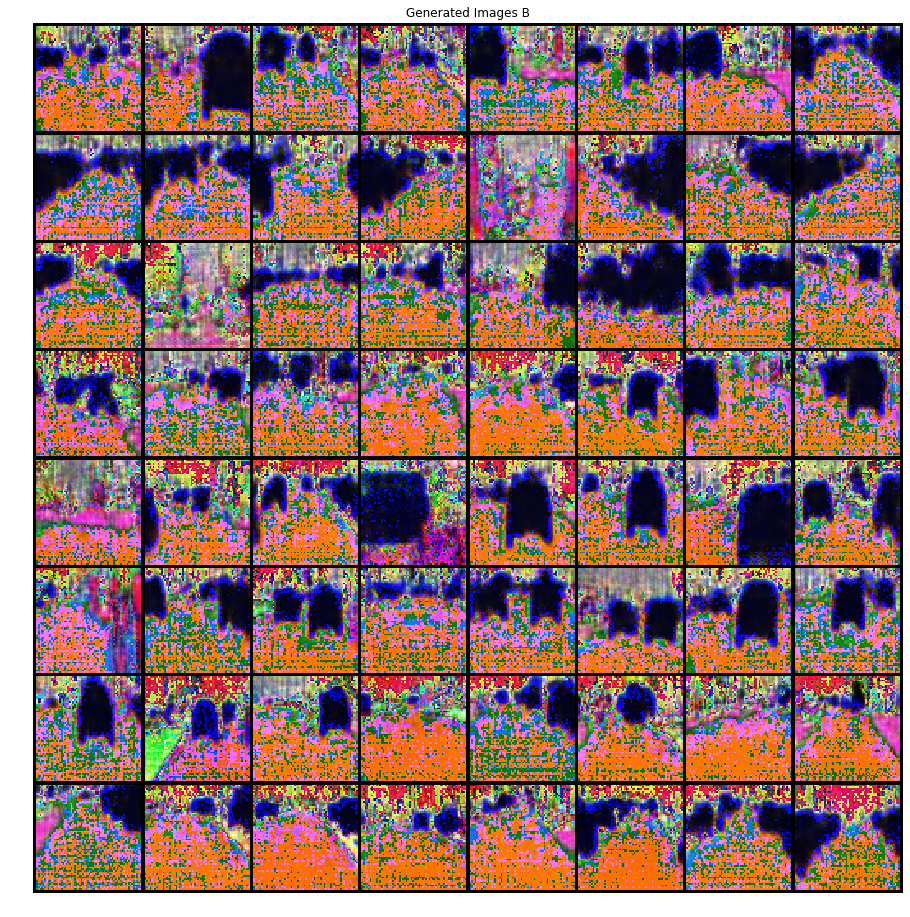

In [24]:
plt.figure(figsize=(16,16))
plt.axis("off")
plt.title("Generated Images A")
plt.imshow(plt.imread("{}/epoch{}_gen_b2a.png".format(trainer.recon, trainer.epochs)))
plt.show()
plt.figure(figsize=(16,16))
plt.axis("off")
plt.title("Generated Images B")
plt.imshow(plt.imread("{}/epoch{}_gen_a2b.png".format(trainer.recon, trainer.epochs)))
plt.show()